In [1]:
import argparse
import cv2
import numpy as np
import networkx as nx
import os
from itertools import combinations
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import Compose
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from viz_3d import *

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d

import pypose as pp

from SLAM.TUM_dataset import TUMVisualInertialDataset

import pytorch3d

os.chdir("./DepthAnything/")
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

In [2]:
from pytorch3d.renderer.fisheyecameras import FishEyeCameras
from scipy.spatial.transform import Rotation as R

In [3]:
x = torch.arange(0, 512, 20)
y = torch.arange(0, 512, 20)
xx, yy = torch.meshgrid(x, y)

# Reshape to shape (N, 2)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Add a column of ones to make it shape (N, 3)
xy1 = torch.cat([xy, torch.ones(xy.shape[0], 1)], dim=1)

c:\Users\pajul\anaconda3\envs\matine\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
Rot = R.random().as_matrix()
cam = FishEyeCameras(
    focal_length=torch.tensor([190.97847715128717]).repeat(2, 1),
    principal_point=torch.tensor([[254.93170605935475, 256.8974428996504]]),
    radial_params=torch.tensor(
        [
            [
                0.373004838186,
                0.372994740336,
                0.498890050897,
                0.502729380663,
                0.00348238940225,
                0.000715034845216,
            ]
        ]
    ),
    # tangential_params=tensor([[0., 0.]]),
    # thin_prism_params=tensor([[0., 0., 0., 0.]]),
    R=torch.tensor([np.eye(3)]),
    T=torch.tensor([[0.0, 0.0, 0.0]]),
    world_coordinates=True,
    use_radial=True,
    use_tangential=False,
    use_thin_prism=False,
    device="cpu",
    image_size=(512, 512),
)

out = cam.unproject_points(xy1, world_coordinates=True, scaled_depth_input=False)
out

C:\Users\pajul\AppData\Local\Temp\ipykernel_16144\3688699569.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  R=torch.tensor([np.eye(3)]),


tensor([[-0.9053, -0.9123,  1.0000],
        [-0.9219, -0.8567,  1.0000],
        [-0.9384, -0.7984,  1.0000],
        ...,
        [ 0.9227,  0.7647,  1.0000],
        [ 0.9062,  0.8249,  1.0000],
        [ 0.8895,  0.8824,  1.0000]])

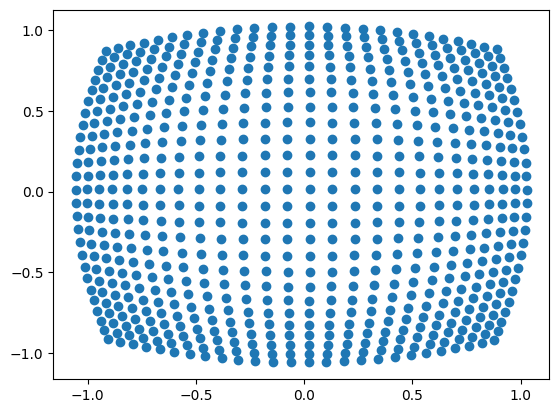

In [5]:
plt.scatter(*out[:, :2].numpy().T)

In [6]:
cam.transform_points(out)

tensor([[  0.0000,   0.0000,   1.0000],
        [  0.0000,  20.0000,   1.0000],
        [  0.0000,  40.0000,   1.0000],
        ...,
        [500.0000, 460.0000,   1.0000],
        [500.0000, 480.0000,   1.0000],
        [499.9999, 499.9999,   1.0000]])

### Initialize Dataset

torch.Size([10, 3, 518, 518]) torch.Size([987, 1]) torch.Size([987, 3]) torch.Size([987, 3]) torch.Size([10, 7])


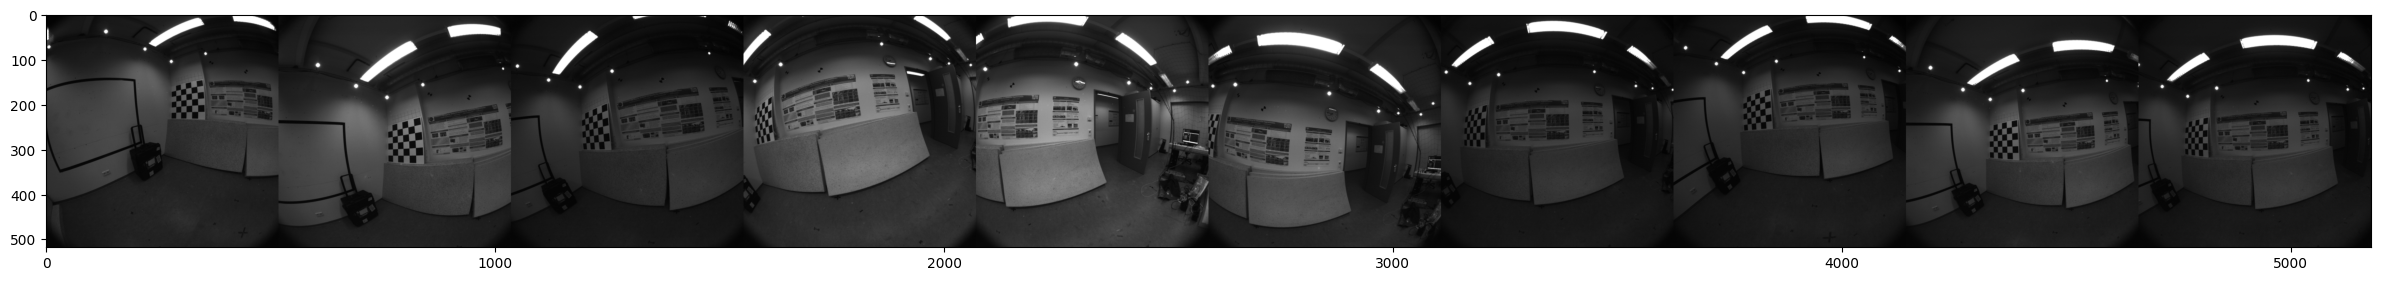

In [7]:
transform = Compose(
    [
        Resize(
            width=518,
            height=518,
            resize_target=False,
            keep_aspect_ratio=True,
            ensure_multiple_of=14,
            resize_method="lower_bound",
            image_interpolation_method=cv2.INTER_CUBIC,
        ),
        # NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # PrepareForNet(),  # this makes the image (and training masks) contiguous and floats
    ]
)

seq_len = 10

dataset = TUMVisualInertialDataset(
    path="../datasets/dataset-corridor4_512_16/dso",
    # path="/home/ilari/Downloads/dataset-corridor4_512_16/dso",
    transforms=transform,
    sequence_length=seq_len,
    skip_frames=10,
)

X = dataset[0]
print(X["cam0"].shape, X["dt"].shape, X["acc"].shape, X["gyro"].shape, X["gt_pose"].shape)

s, h, w, c = X["cam0"].shape

plt.figure(figsize=(30, 10))
plt.imshow(np.concatenate(tuple(X["cam0"].permute(0, 2, 3, 1)), axis=1))

In [8]:
np.concatenate((np.zeros((1, 3)), np.ones((10, 3))))

array([[0., 0., 0.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

### Initialize Models

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Camera model
fish_cam = FishEyeCameras(
    focal_length=torch.tensor([190.97847715128717]).repeat(2, 1),
    principal_point=torch.tensor([[254.93170605935475, 256.8974428996504]]),
    radial_params=torch.tensor(
        [
            [
                0.373004838186,
                0.372994740336,
                0.498890050897,
                0.502729380663,
                0.00348238940225,
                0.000715034845216,
            ]
        ]
    ),
    # tangential_params=tensor([[0., 0.]]),
    # thin_prism_params=tensor([[0., 0., 0., 0.]]),
    R=torch.tensor([np.eye(3)]),
    T=torch.tensor([[0.0, 0.0, 0.0]]),
    world_coordinates=True,
    use_radial=True,
    use_tangential=False,
    use_thin_prism=False,
    device=device,
    image_size=(512, 512),
)


# Depth Anything
depth_anything = DepthAnything.from_pretrained("LiheYoung/depth_anything_vitb14").to(device).eval()
total_params = sum(param.numel() for param in depth_anything.parameters())
print("DepthAnything parameters: {:.2f}M".format(total_params / 1e6))

# Extractor and matcher
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)


# IMU
integrator = pp.module.IMUPreintegrator(gyro_cov=0.00016, acc_cov=0.0028, reset=True).to(device)

cuda


A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\pajul\anaconda3\envs\matine\lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
  File "c:\Users\pajul\anaconda3\envs\matine\lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'


DepthAnything parameters: 97.47M


In [10]:
def DepthAnythingProcess(batch):
    mean = torch.tensor([0.485, 0.456, 0.406], device=batch.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=batch.device).view(1, 3, 1, 1)
    batch = (batch - mean) / std
    batch = batch.contiguous()
    return batch


def extract_keypoints(image, extractor, device):
    # image = load_image(img_path)
    feats = extractor.extract(image.to(device))
    return feats


def match_keypoints(feats0, feats1, matcher):
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    return m_kpts0, m_kpts1, matches01


def covisibility_graph(num_cams, matches):
    G = nx.Graph()
    for cam_idx in range(num_cams - 1):
        for i, j in matches[cam_idx]:
            G.add_edge((cam_idx, i), (cam_idx + 1, j))

    TC = nx.transitive_closure(G, reflexive=False)
    components = nx.connected_components(TC)
    points3D = [sublist for sublist in components if len(sublist) >= 3]

    cam2pointidx = defaultdict(list)
    for pt_idx, pt in enumerate(points3D):
        for cam, _ in pt:
            cam2pointidx[cam].append(pt_idx)

    return points3D, cam2pointidx


def project_keypoint_batch(camera_model, poses, batch_keypoints, batch_depths):
    points3D = []
    for pose, keypoints, depths in zip(poses, batch_keypoints, batch_depths):
        U, V = torch.split(keypoints["keypoints"].int(), 1, dim=-1)
        keypoint_depths = depths[U, V]
        u_vectors = F.normalize(camera_model.unproject_points(keypoints["keypoints"]))
        points = pose @ (u_vectors * keypoint_depths)
        points3D.append(points)
    return points3D


def triangulate_matched_points(covis_graph, camera_model, poses, batch_keypoints, batch_depths):
    cam2point = defaultdict(list)
    points3D = []
    for i, point in enumerate(covis_graph):
        mean_point = []
        for cam, feature_idx in point:
            pose = poses[cam]
            keypoint = batch_keypoints[cam]["keypoints"][0, feature_idx]
            depth = batch_depths[cam, int(keypoint[0]), int(keypoint[1])]
            unit_vector = F.normalize(camera_model.unproject_points(keypoint[None]))
            point3d = pose @ (unit_vector * depth)
            mean_point.append(point3d)
            # Mapping: cam -> (keypoint_idx, 3Dpoints_idx)
            cam2point[cam].append((feature_idx, i))
        points3D.append(torch.vstack(mean_point).mean(dim=0))
    points3D = torch.vstack(points3D)
    return points3D, cam2point


# def project_keypoint_batch(camera_model, poses, batch_keypoints, batch_depths):
#     points3D = []
#     K = torch.tensor(dataset.K, device=device)
#     for pose, keypoints, depths in zip(poses, batch_keypoints, batch_depths):
#         keypoints = keypoints['keypoints'][0] # [N, 2]
#         N = keypoints.shape[0]
#         keypoint_depths = depths[keypoints[:,0].int(), keypoints[:,1].int()]
#         keypoints = torch.cat((keypoints, torch.ones(N, device=keypoints.device).view(-1,1)), dim=-1)
#         undistorted_pixels = F.normalize(camera_model.transform_points(keypoints))[:, :2]
#         points = pp.pixel2point(undistorted_pixels, keypoint_depths, torch.eye(3, device=device))
#         points3D.append(points)
#     return points3D


def batch2device(tensor_dict, device):
    return {k: v.to(device) for k, v in tensor_dict.items()}

In [11]:
K = torch.tensor(dataset.K).float().to(device)

In [25]:
# Training loop
for batch_idx, data in enumerate(dataset):
    data = batch2device(data, device)
    image_batch = data["cam0"]
    feature_points = []
    pixel_matches = []
    all_matches = []

    # Get initial poses through IMU
    init_state = {"pos": data["gt_pose"][0].translation(), "rot": data["gt_pose"][0].rotation(), "vel": data["velocity"]}
    state = integrator(dt=data["dt"], gyro=data["gyro"], acc=data["acc"], init_state=init_state)

    imu_freq = data["dt"].shape[0] // image_batch.shape[0]
    imu_poses = pp.SE3(torch.cat((state["pos"], state["rot"]), dim=-1))
    imu_poses = imu_poses[0, ::imu_freq][: image_batch.shape[0]]

    # Extract keypoints
    for i in range(image_batch.shape[0]):
        feature_points.append(extract_keypoints(image_batch[i : i + 1], extractor, device))

    # Match keypoints
    for i in range(len(feature_points) - 1):
        m_kpts0, m_kpts1, matches01 = match_keypoints(feature_points[i], feature_points[i + 1], matcher)
        all_matches.append(matches01["matches"].cpu().numpy())
        pixel_matches.append((m_kpts0, m_kpts1))

    # Create covisibility graph
    covis_graph, cam2point = covisibility_graph(image_batch.shape[0], all_matches)

    image_batch = DepthAnythingProcess(image_batch)

    with torch.no_grad():
        depths = depth_anything(image_batch)
        depths = depths / 5  # Scale depth if needed

    # Naive, extremely slow point triangulation, ~2mins for 1000 points.
    # points3D, cam2point = triangulate_matched_points(covis_graph, fish_cam, imu_poses, feature_points, depths)

    # if batch_idx > 50:
    break

c:\Users\pajul\anaconda3\envs\matine\lib\site-packages\pypose\lietensor\lietensor.py:918: UserWarning: Tensor Shape Invalid by calling <built-in method cat of type object at 0x00007FF803754D40>, go to https://pypose.org/docs/main/generated/pypose.LieTensor
  warnings.warn('Tensor Shape Invalid by calling {}, ' \


In [35]:
import torch
import torch.nn as nn
from torch_geometric.data import HeteroData


class SceneGraph(nn.Module):
    def __init__(self, init_poses, all_matches):
        super(SceneGraph, self).__init__()
        self.graph = HeteroData()
        self.graph["camera"].x = nn.Parameter(init_poses)
        self.point_id_counter = 0  # Counter to assign unique IDs to points
        self.point_to_id = {}  # Mapping from point coordinates to point IDs
        self.populate_graph(all_matches)

    def populate_graph(self, all_matches):
        for frame_id, (matches_prev, matches_curr) in enumerate(all_matches):
            if frame_id == 0:  # For the first frame, initialize points
                for u, v in matches_curr:
                    point_id = self.point_id_counter
                    self.graph["point"].x = (
                        torch.cat([self.graph["point"].x, torch.tensor([[u, v]])], dim=0)
                        if "point" in self.graph
                        else torch.tensor([[u, v]])
                    )
                    self.point_to_id[(u.item(), v.item())] = point_id
                    self.point_id_counter += 1
            else:
                self.register_3Dpoints(frame_id - 1, frame_id, matches_prev, matches_curr)

    def register_3Dpoints(self, cam0, cam1, matches_prev, matches_curr):
        # Iterate over the matches between the current and previous frames
        for (u_prev, v_prev), (u_curr, v_curr) in zip(matches_prev, matches_curr):
            # If the previous match point exists, use its ID; otherwise, create a new point
            prev_point_id = self.point_to_id.get((u_prev.item(), v_prev.item()))
            if prev_point_id is not None:
                # Link the current point to the same ID
                self.point_to_id[(u_curr.item(), v_curr.item())] = prev_point_id
            else:
                # Create a new point for the current frame
                point_id = self.point_id_counter
                self.graph["point"].x = torch.cat([self.graph["point"].x, torch.tensor([[u_curr, v_curr]])], dim=0)
                self.point_to_id[(u_curr.item(), v_curr.item())] = point_id
                self.point_id_counter += 1

    def match_indices(self, A, B):
        # Finds A[indices] == B for 2D tensors A and B.
        values, indices = torch.topk(((A.t() == B.unsqueeze(-1)).all(dim=1)).int(), 1, 1)
        indices = indices[values != 0]
        return indices

    def forward(self, graph):
        # Calculate reprojection error, does not need to be implemented.
        pass


G = SceneGraph(imu_poses, pixel_matches)

In [40]:
print(G.graph)
len(covis_graph)

HeteroData(
  camera={ x=[10, 7] },
  point={ x=[1570, 2] }
)


1139

In [41]:
covis_graph

[{(0, 14), (1, 49), (2, 32), (3, 57)},
 {(0, 16), (1, 70), (2, 60)},
 {(0, 24), (1, 83), (2, 65)},
 {(0, 31), (1, 96), (2, 92)},
 {(0, 35), (1, 104), (2, 97)},
 {(0, 36), (1, 105), (2, 94)},
 {(0, 54), (1, 123), (2, 81)},
 {(0, 63), (1, 132), (2, 93)},
 {(0, 68), (1, 136), (2, 99)},
 {(0, 69), (1, 146), (2, 124)},
 {(0, 71), (1, 99), (2, 50)},
 {(0, 90), (1, 150), (2, 100), (3, 183)},
 {(0, 92), (1, 148), (2, 90)},
 {(0, 95), (1, 162), (2, 122)},
 {(0, 99), (1, 156), (2, 104)},
 {(0, 101), (1, 171), (2, 128)},
 {(0, 104),
  (1, 151),
  (2, 82),
  (3, 144),
  (4, 238),
  (5, 213),
  (6, 122),
  (7, 82),
  (8, 174),
  (9, 149)},
 {(0, 106), (1, 183), (2, 147)},
 {(0, 107), (1, 181), (2, 149)},
 {(0, 108),
  (1, 163),
  (2, 98),
  (3, 171),
  (4, 262),
  (5, 204),
  (6, 132),
  (7, 89),
  (8, 183),
  (9, 159)},
 {(0, 109), (1, 153), (2, 83)},
 {(0, 110), (1, 141), (2, 69)},
 {(0, 112), (1, 191), (2, 161)},
 {(0, 113), (1, 157), (2, 87), (3, 152)},
 {(0, 114), (1, 154), (2, 85), (3, 149), 

### Visualize Poses and Points for Initialized Conditions

In [ ]:
def visualize_batch(poses, gt_poses, points):
    fig = init_figure()
    fig.update_layout(showlegend=True)
    for pose, gt_pose in zip(poses, gt_poses):
        R = pose.rotation().matrix().cpu().numpy()
        t = pose.translation().cpu().numpy()
        Rgt = gt_pose.rotation().matrix().cpu().numpy()
        tgt = gt_pose.translation().cpu().numpy()
        K = dataset.K

        plot_camera(fig, Rgt, tgt, K, text="gt", size=1, color="blue")
        plot_camera(fig, R, t, K, text="pred", size=1, color="green")

    X = points.cpu().numpy().squeeze()
    plot_points(fig, X, color="red")

    fig.show()


visualize_batch(imu_poses, data["gt_pose"], points3D)

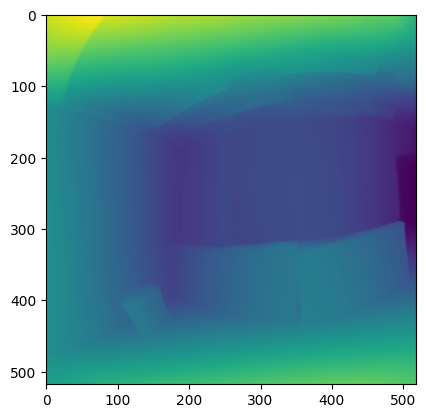

In [ ]:
depths = (depths - depths.min()) / (depths.max() - depths.min()) * 255.0
plt.imshow(depths[8].cpu().numpy())

In [ ]:
# Initialize two new dictionaries
cam2points2d = defaultdict(list)
cam2points3d = defaultdict(list)

# Iterate over each item in the original dictionary
for key, value_list in cam2point.items():
    for value in value_list:
        # Unpack each tuple
        point2d, point3d = value
        # Append the first element of the tuple to cam2points2d
        cam2points2d[key].append(point2d)
        # Append the second element of the tuple to cam2points3d
        cam2points3d[key].append(point3d)

### Bundle Adjustment

In [ ]:
### CPU for debugging ###
Kcpu = K.cpu()
points2D = {i: v["keypoints"][0].cpu() for i, v in enumerate(feature_points)}
points = nn.Parameter(points3D.cpu())
poses_pred = pp.Parameter(imu_poses.cpu())
poses_gt = data["gt_pose"].cpu()

# Initialize the optimizer
optimizer = torch.optim.Adam([points, poses_pred], lr=0.01)
lossf = nn.MSELoss()
# Run Bundle Adjustment
n_iter = 20  # fix the number of iterations
for it in range(n_iter):
    optimizer.zero_grad()

    loss = 0

    for cam in range(seq_len):
        indices = cam2point[cam]
        pts3d = points[cam2points3d[cam]]
        pts2d = points2D[cam][cam2points2d[cam]]
        pose = poses_pred[cam]
        loss = loss + pp.reprojerr(pts3d, pts2d, Kcpu, pose, reduction="norm").sum()

    # loss = loss + 1000*(poses_pred.Inv() @ poses_gt).sum()

    # our loss function is the camera_distance
    loss.backward()

    # apply the gradients
    optimizer.step()

    print(f"Loss : {loss.item()}")

print("Optimization finished.")

Loss : 10002399.0
Loss : 5688383.0
Loss : 19459530.0
Loss : 4513232.0
Loss : 9191529.0
Loss : 32268862.0
Loss : 4992624.0
Loss : 10698300.0
Loss : 3949828.5
Loss : 3860098.5
Loss : 4253403.5
Loss : 7903425.5
Loss : 7683279.0
Loss : 4848209.0
Loss : 4744235.5
Loss : 3916057.0
Loss : 3717631.25
Loss : 4561177.0
Loss : 8374025.5
Loss : 4314684.5
Optimization finished.


In [ ]:
visualize_batch(poses_pred.detach(), data["gt_pose"], points.data)

In [ ]:
breakhere
points2D = {i: v["keypoints"] for i, v in enumerate(feature_points)}
points = nn.Parameter(points3D)
poses_pred = nn.Parameter(imu_poses)
poses_gt = data["gt_pose"]

# Initialize the optimizer
optimizer = torch.optim.Adam([points, poses_pred], lr=1e-3)
lossf = nn.MSELoss()

# Run Bundle Adjustment
n_iter = 50  # fix the number of iterations
for it in range(n_iter):
    optimizer.zero_grad()

    loss = 0

    for cam in range(seq_len):
        indices = cam2point[cam]
        pts3d = points[cam2points3d[cam]]
        pts2d = points2D[cam][cam2points2d[cam]]
        pose = poses_pred[cam]
        print(pts2d.shape, pts3d.shape)
        loss = loss + pp.reprojerr(pts3d, pts2d, K, pose, reduction="norm").sum()

    # our loss function is the camera_distance
    loss.backward()

    # apply the gradients
    optimizer.step()

    print(f"Loss : {loss.item()}")

print("Optimization finished.")

NameError: name 'breakhere' is not defined

In [ ]:
pts3d.shape, pts2d.shape

(torch.Size([615, 3]), torch.Size([615, 956, 2]))

In [ ]:
class Point(nn.Module):
    def __init__(self, X, uv_matches):
        super(Point, self).__init__()
        """
        A 3D point class, cameras and indices need to have length N.
        """
        self.X = nn.Parameter(X.detach().clone().view(1, 3))
        self.uv_matches = uv_matches  # Dict of cam_idx -> (u,v) pixel values.

    def forward(self, cam_idx):
        # reprojections = []
        pixel_gts = []
        for cam, id in zip(self.cameras, self.pt_idxs):
            pixel_gts.append(cam.points_2d[id])
        #     #P = cam()
        #     #pt = P @ convert_points_to_homogeneous(self.X).T
        #     #pt = pp.point2pixel(self.X, cam.K, cam.extrinsics)
        #     reprojections.append(pt)
        # reprojections = torch.vstack(reprojections)
        pixel_gts = torch.vstack(pixel_gts)
        points = self.X.expand(pixel_gts.size(0), -1)
        return points, pixel_gts


class Camera(nn.Module):
    def __init__(self, i, K, R, t):
        super(Camera, self).__init__()
        """
        R and t are provided as initial estimates derived with the IMU.
        """
        self.i = i
        self.points = []  # List of Point(nn.Module)
        self.K = K.detach().clone().float()
        self.K.requires_grad = False
        self.extrinsics = pp.Parameter(pp.mat2SE3(torch.cat((R, t[:, None]), dim=-1).detach().clone()))

    def forward(self):
        Xs = []
        pixel_pairs = []
        for pt in self.points:
            Xs.append(pt.X)
            pixel_pairs.append(pt.uv_matches[self.i])
        Xs = torch.vstack(Xs)
        pixel_pairs = torch.vstack(pixel_pairs)
        return Xs, pixel_pairs, self.K, self.extrinsics

    def initialize_point(self, point):
        self.points.append(point)